
# COVID-Team-1
### Dr. Mohanty
### Brantley, Kawabata, Urgitus
### CSC 405 01
### Last Updated: 10/19/2020
### We, the members of COVID-Team-1, have abided by the UNCG academic policy.

### Module Imports

In [1]:
import ipynb
from ipynb.fs.full import covid_data as cd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

### Pandas Display Options

In [2]:
# Telling pandas not convert to html tags.
pd.set_option('display.notebook_repr_html', False)
# Max columns and rows to display.
pd.set_option('display.max_columns', 12)
pd.set_option('display.max_rows', 10)

## Calculating Weekly Statistics

In [3]:
# Get covid daily cases.
df_daily_cases = cd.get_covid_daily_cases_normalized()
# Get primary data and group by state.
df_primary = cd.get_covid_primary_data()
df_primary_states = df_primary.groupby("State")
# Calculate the number of columns, i.e. days.
number_days = len(df_primary_states.first().filter(regex = "case").columns)
# Declaring/Initializing our state/week lists which will form our indexes.
state_index = []
week_index = []
# Keeps track of which week we are on.
week_count = 1
# Appends a state to the state index.
# Appends ((number_days) / 7) weeks into week index.
# Populating our lists, which will be used for multi indexing.
for state in df_daily_cases.index:
    for week in range (0, number_days, 7):
        state_index.append(state)
        week_index.append("week " + str(week_count))
        week_count += 1
    week_count = 1
# Creating temporary dataframe to hold mean for cases and deaths.
df_weekly_statistics = pd.DataFrame(index = [state_index, week_index],\
                                   columns = ["mean_cases", "mean_deaths", "start_day"])
# Creating our daily statistics dataframe for cases.
df_statistics_cases = pd.DataFrame(index = df_daily_cases.index,\
                                   columns = ["mean", "median", "mode"])
# Creating our daily statistics dataframe for deaths.
df_daily_deaths = cd.get_covid_daily_deaths_normalized()
df_statistics_deaths = pd.DataFrame(index = df_daily_cases.index,\
                                   columns = ["mean", "median", "mode"])
# Calculating weekly mean for cases and deaths.
# Week count starts at 0, it is now used for index positioning.
week_count = 0
for lower_range in range(0, number_days, 7):
    upper_range = lower_range + 7
    for state in df_daily_cases.index:
        # Get weekly statistics for cases.
        df_weekly_statistics.loc[state].iloc[week_count]["mean_cases"]\
            = round(df_daily_cases.loc[state].iloc[lower_range:upper_range].mean(), 0)
        df_weekly_statistics.loc[state].iloc[week_count]["start_day"]\
            = df_daily_cases.loc[state].index[lower_range]
        # Get weekly statistics for deaths.
        df_weekly_statistics.loc[state].iloc[week_count]["mean_deaths"]\
            = round(df_daily_deaths.loc[state].iloc[lower_range:upper_range].mean(), 0)
    week_count += 1
# Calculating the mean/median/mode for each state, determined from values from all weeks.
for state in df_weekly_statistics.index.get_level_values(0).unique():
    df_statistics_cases.loc[state, "mean"] = df_weekly_statistics.loc[state]["mean_cases"].mean()
    df_statistics_cases.loc[state, "median"] = df_weekly_statistics.loc[state]["mean_cases"].median()
    df_statistics_cases.loc[state, "mode"] = df_weekly_statistics.loc[state]["mean_cases"].mode()[0]
    df_statistics_deaths.loc[state, "mean"] = df_weekly_statistics.loc[state]["mean_deaths"].mean()
    df_statistics_deaths.loc[state, "median"] = df_weekly_statistics.loc[state]["mean_deaths"].median()
    df_statistics_deaths.loc[state, "mode"] = df_weekly_statistics.loc[state]["mean_deaths"].mode()[0]

### Statistics for Cases by State

In [4]:
display(df_statistics_cases)

          mean median mode
State                     
AK     376.171    156    0
AL     1220.83    770    0
AR      1038.4    573    0
AZ     1200.43    556    0
CA     814.971    578    0
...        ...    ...  ...
VT     111.086     94    0
WA     442.457    413    0
WI     753.343    558    0
WV     330.743    199    0
WY     376.229    205    0

[51 rows x 3 columns]

### Statistics for Deaths by State

In [5]:
display(df_statistics_deaths)

          mean median mode
State                     
AK     2.51429      0    0
AL     20.1143     21    0
AR        27.6      8    0
AZ     31.0571     26    0
CA     15.7714     17    0
...        ...    ...  ...
VT     3.71429      0    0
WA     10.9429     10    0
WI     8.97143     10    0
WV     8.85714      3    0
WY     4.31429      0    0

[51 rows x 3 columns]

## Comparing Case Statistics

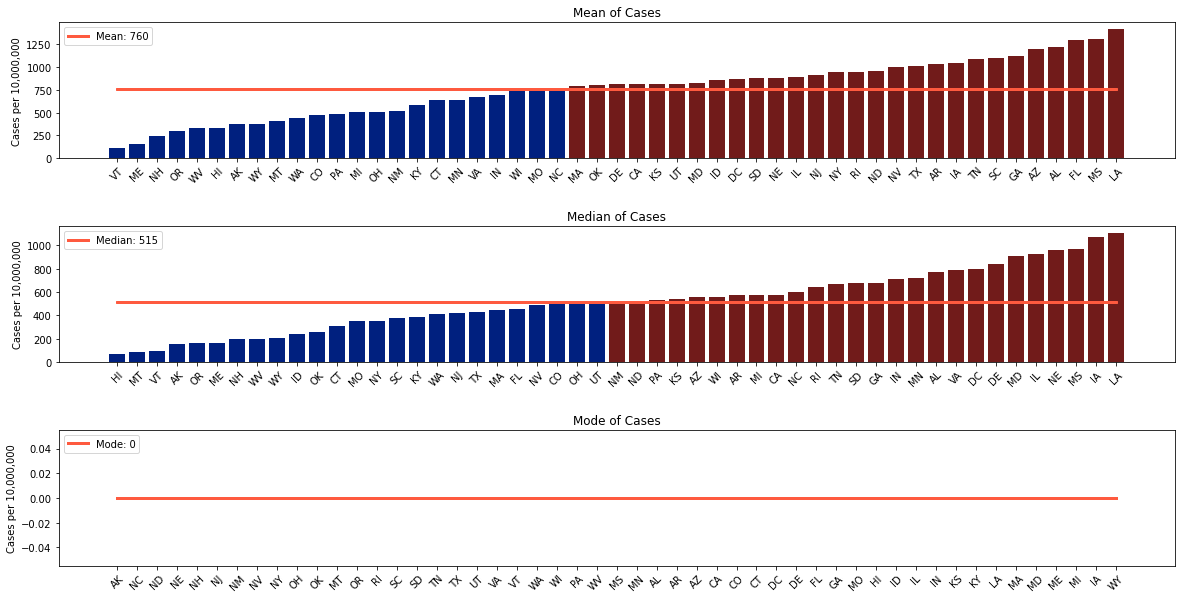

In [6]:
x = df_statistics_cases.index.tolist()
# Sorting columns by ascending order for each statistical measurement.
y_mean = df_statistics_cases.sort_values(by = "mean", ascending = True)["mean"]
y_median = df_statistics_cases.sort_values(by = "median", ascending = True)["median"]
y_mode = df_statistics_cases.sort_values(by = "mode", ascending = True)["mode"]
# Creating 3 subplots with padding of .5.
figure, axis = plt.subplots(3, gridspec_kw={'hspace': .5}, figsize = (20,10))
# Creating our subplots.
for axis_num, y_data, title in zip(range(0,3,1), (y_mean, y_median, y_mode), ("Mean", "Median", "Mode")):
    # Calculate the statistical measurement for all states.
    stat_data = eval("df_statistics_cases['" + title.lower() + "']." + title.lower() + "()")
    # Necessary due to mode returning an array.
    # Creates bar graph with color based on above/below statistical measurement.
    try:
        bars = axis[axis_num].bar(y_data.index.tolist(), y_data, color = \
                                  ["#711B1A" if data >= stat_data else "#00207F" for data in y_data])
    except:
        # Must use [0] here on stat_data to retrieve mode.
        bars = axis[axis_num].bar(y_data.index.tolist(), y_data, color = \
                                  ["#711B1A" if data >= stat_data[0] else "#00207F" for data in y_data])
    # Beautifying graph.
    axis[axis_num].title.set_text(title + " of Cases")
    axis[axis_num].set_ylabel("Cases per 10,000,000")
    axis[axis_num].tick_params(axis = "x", rotation = 45)
    # Necessary due to mode returning an array.
    # Creates plot of our statistical measurement.
    try:
        axis[axis_num].plot(x, np.full((51), fill_value = stat_data),\
                            linewidth = 3, color = "#FE5A3F", label = (title + ": {:.0f}".format(stat_data)))
    except:
        axis[axis_num].plot(x, np.full((51), fill_value = stat_data),\
                        linewidth = 3, color = "#FE5A3F", label = (title + ": {:.0f}".format(stat_data[0])))
    axis[axis_num].legend(loc = "upper left")
plt.show()

Graphing with cases per 10,000,000 gives us a more accurate analysis of covid cases in each state by comparing the normalized values. In other words, we can see that our highest population states such as California, Texas, Florida, and New York are not necessarily our top performers. The mean of cases is better for considering the entire dataset and shows us that Louisiana, Mississippi, and Florida have highest number of cases. The median of cases is better for excluding outliers within the data and shows us that Louisiana, Iowa, and Mississippi have highest number of cases.

The color change in the bars of both graphs highlights which states are performing either below (blue) or above (red) the statistical measure for all states. When looking at "Mean of Cases" we can see that more bars are colored red in "Mean of Cases" which indicates that the mean of cases for each state is being affected by outliers.  Because the mean is being pulled lower we know that our median is a better measure of our dataset.

To conclude, we would utilize our measurements from "Median of Cases", and list Louisiana, Iowa, and Mississippi as our highest performers for cases.

## Comparing Death Statistics

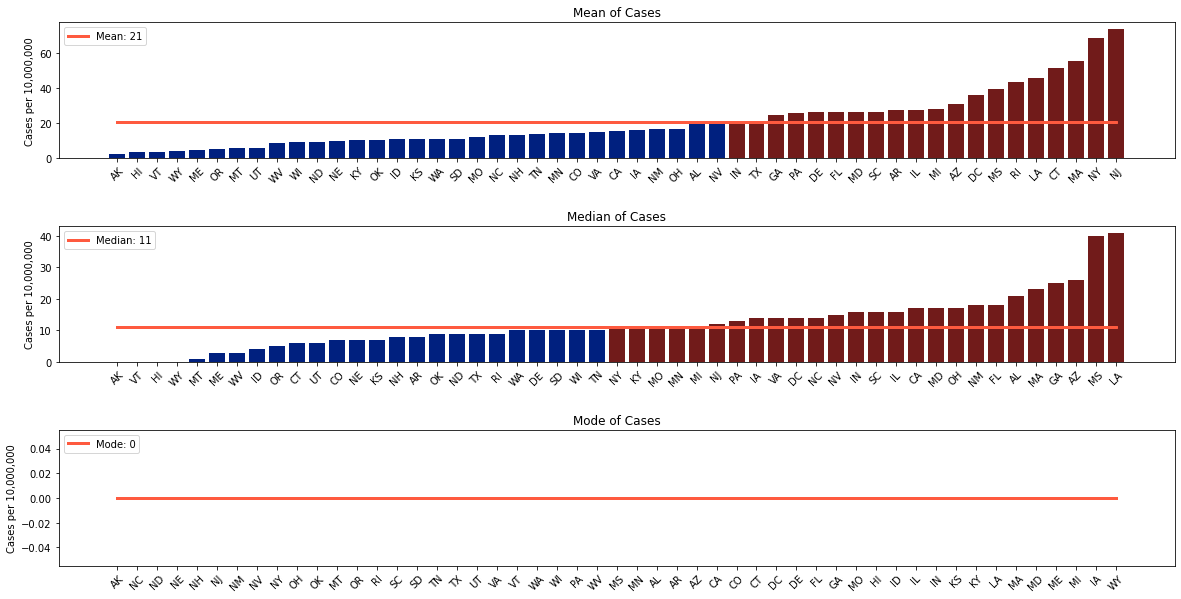

In [7]:
# Sorting columns by ascending order for each statistical measurement.
y_mean = df_statistics_deaths.sort_values(by = "mean", ascending = True)["mean"]
y_median = df_statistics_deaths.sort_values(by = "median", ascending = True)["median"]
y_mode = df_statistics_deaths.sort_values(by = "mode", ascending = True)["mode"]
# Creating 3 subplots with padding of .5.
figure, axis = plt.subplots(3, gridspec_kw={'hspace': .5}, figsize = (20,10))
# Creating our subplots.
for axis_num, y_data, title in zip(range(0,3,1), (y_mean, y_median, y_mode), ("Mean", "Median", "Mode")):
    # Calculate the statistical measurement for all states.
    stat_data = eval("df_statistics_deaths['" + title.lower() + "']." + title.lower() + "()")
    # Necessary due to mode returning an array.
    # Creates bar graph with color based on above/below statistical measurement.
    try:
        bars = axis[axis_num].bar(y_data.index.tolist(), y_data, color = \
                                  ["#711B1A" if data >= stat_data else "#00207F" for data in y_data])
    except:
        bars = axis[axis_num].bar(y_data.index.tolist(), y_data, color = \
                                  ["#711B1A" if data >= stat_data[0] else "#00207F" for data in y_data])
    # Beautifying graph.
    axis[axis_num].title.set_text(title + " of Cases")
    axis[axis_num].set_ylabel("Cases per 10,000,000")
    axis[axis_num].tick_params(axis = "x", rotation = 45)
    try:
        axis[axis_num].plot(x, np.full((51), fill_value = stat_data),\
                            linewidth = 3, color = "#FE5A3F", label = (title + ": {:.0f}".format(stat_data)))
    except:
        axis[axis_num].plot(x, np.full((51), fill_value = stat_data),\
                        linewidth = 3, color = "#FE5A3F", label = (title + ": {:.0f}".format(stat_data[0])))
    # Necessary due to mode returning an array.
    # Creates plot of our statistical measurement.
    axis[axis_num].legend(loc = "upper left")
plt.show()

From the "Mean of Deaths" graph we see that New Jersey, New York, and Massachusetts are our top performers. From the "Median of Deaths" graph we see that Louisiana, Mississippi, and Arizona are our top performers. When we compare the mean and mode of the "Mean of Deaths" graphs we can see that our dataset is highly affected by outliers because the mean has few states performing above the mean.

To conclude, the median is the better measurement of our dataset. Louisiana, Mississippi, and Arizona are our top performers for deaths.

# Compare the data against other countries of the world.

In [8]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option("display.max_rows", 10, "display.max_columns", None)

In [9]:
world_cases = pd.read_csv('../data/Covid_International/new_cases_normalized.csv')
world_deaths = pd.read_csv('../data/Covid_International/new_deaths_normalized.csv')
cases_date = world_cases["Date"]
deaths_date = world_deaths["Date"]
countries_cases = world_cases[['Brazil', 'Russia', 'Pakistan', 'Nigeria', 'Japan','United_States_of_America']]
countries_deaths = world_cases[['Brazil', 'Russia', 'Pakistan', 'Nigeria', 'Japan', 'United_States_of_America']]
countries_cases.insert(loc=0, column="Date", value=cases_date)
countries_deaths.insert(loc=0, column="Date", value=deaths_date)
world_cases = countries_cases
worlds_deaths = countries_deaths
world_cases = world_cases.loc[21:].reset_index(drop=True)
world_deaths = world_deaths.loc[21:].reset_index(drop=True)
num_days = len(world_cases.index)
num_weeks = int(num_days/7)
week_index = []
country_index = []
start_date_column = []

for country in world_cases.columns[1:]:
    for week_number in range(0, num_weeks):
        week_index.append("week " + str(week_number+1))
        start_date_column.append(world_cases.iloc[week_number*7,0])
        country_index.append(country)
        
weekly_means = pd.DataFrame(index = [country_index, week_index], \
                            columns = ["mean_cases", "mean_deaths", "start_date"])

world_cases_statistics = pd.DataFrame(index = world_cases.columns[1:], \
                            columns = ["mean", "median", "mode"])

world_deaths_statistics = pd.DataFrame(index = world_cases.columns[1:], \
                            columns = ["mean", "median", "mode"])

weekly_means["start_date"] = start_date_column
weekly_means.index.set_names(['Country', 'Week'])

for country in world_cases.columns[1:]:
    for week_number in range(0, num_weeks):
        start = week_number * 7
        end = start + 6
        cases_mean = int(world_cases.iloc[start:end][country].mean())
        deaths_mean = int(world_deaths.iloc[start:end][country].mean())
        week = "week " + str(week_number + 1)
        weekly_means.loc[country, week]["mean_cases"] = cases_mean
        weekly_means.loc[country, week]["mean_deaths"] = deaths_mean


        
for country in world_cases_statistics.index:
    world_cases_statistics.loc[country]["mean"] = float(weekly_means.loc[country]['mean_cases'].mean())
    world_cases_statistics.loc[country]["median"] = int(weekly_means.loc[country]['mean_cases'].median())
    world_cases_statistics.loc[country]["mode"] = int(weekly_means.loc[country]['mean_cases'].mode())
    world_deaths_statistics.loc[country]["mean"] = float(weekly_means.loc[country]['mean_deaths'].mean())
    world_deaths_statistics.loc[country]["median"] = int(weekly_means.loc[country]['mean_deaths'].median())
    world_deaths_statistics.loc[country]["mode"] = int(weekly_means.loc[country]['mean_deaths'].mode())


display(world_cases_statistics)
display(world_deaths_statistics)

                             mean median mode
Brazil                    966.553   1176    0
Russia                    335.605    370    0
Pakistan                  54.8684     26    0
Nigeria                   10.6842      8    0
Japan                     26.9737     17    3
United_States_of_America  900.474    881    0

                               mean median mode
Brazil                      27.9737     35    0
Russia                      5.86842      7    0
Pakistan                   0.815789      0    0
Nigeria                   0.0263158      0    0
Japan                      0.210526      0    0
United_States_of_America       25.5     24    0

# Plot Daily Trends

We will be plotting the daily trends of the cases and deaths in the US and compare them to our 5 chosen countries(Brazil, Russia, Pakistan, Nigeria, and Japan).

In [10]:
# Since we already have the df_daily_cases declared above, we can start by declaring our indecies
state_index = []
day_index = []

# Keeps track of which day we are on.
day_count = 1

for state in df_daily_cases.index:
    for day in range (0, number_days, 1):
        state_index.append(state)
        day_index.append("Day " + str(day_count))
        day_count += 1
    day_count = 1
    
df_daily_statistics = pd.DataFrame(index = [state_index, day_index],\
                                   columns = ["mean_cases", "mean_deaths", "day"])
df_daily_statistics_cases = pd.DataFrame(index = df_daily_cases.index,\
                                   columns = ["mean", "median"])
# Creating our daily statistics dataframe for deaths.
df_daily_deaths = cd.get_covid_daily_deaths_normalized()
df_daily_statistics_deaths = pd.DataFrame(index = df_daily_cases.index,\
                                   columns = ["mean", "median"])
day_count = 0
for lower_range in range(0, number_days, 1):
    upper_range = lower_range + 1
    for state in df_daily_cases.index:
        # Get daily statistics for cases.
        df_daily_statistics.loc[state].iloc[day_count]["mean_cases"]\
            = round(df_daily_cases.loc[state].iloc[lower_range:upper_range].mean(), 0)
        df_daily_statistics.loc[state].iloc[day_count]["day"]\
            = df_daily_cases.loc[state].index[lower_range]
        # Get daily statistics for deaths.
        df_daily_statistics.loc[state].iloc[day_count]["mean_deaths"]\
            = round(df_daily_deaths.loc[state].iloc[lower_range:upper_range].mean(), 0)
    day_count += 1
    
# Getting the mean and median for the daily cases and deaths
for state in df_daily_statistics.index.get_level_values(0).unique():
    df_daily_statistics_cases.loc[state, "mean"] = df_daily_statistics.loc[state]["mean_cases"].mean()
    df_daily_statistics_cases.loc[state, "median"] = df_daily_statistics.loc[state]["mean_cases"].median()
    
    df_daily_statistics_deaths.loc[state, "mean"] = df_daily_statistics.loc[state]["mean_deaths"].mean()
    df_daily_statistics_deaths.loc[state, "median"] = df_daily_statistics.loc[state]["mean_deaths"].median()
    

## Daily Cases For the US

In [11]:
display(df_daily_statistics_cases)

          mean median
State                
AK     368.485    123
AL     1203.94    651
AR     981.067    524
AZ     1206.63    430
CA     816.778    541
...        ...    ...
VT     113.515     64
WA     442.423    391
WI     707.406    489
WV     308.079    151
WY     330.138    190

[51 rows x 2 columns]

## Daily Deaths For the US

In [12]:
display(df_daily_statistics_deaths)

          mean median
State                
AK     2.54812      0
AL     20.3724     12
AR     16.0711      7
AZ     30.8452     14
CA     15.5732     14
...        ...    ...
VT     3.88285      0
WA     11.0921      9
WI      8.8159      5
WV     6.83264      0
WY     3.24268      0

[51 rows x 2 columns]

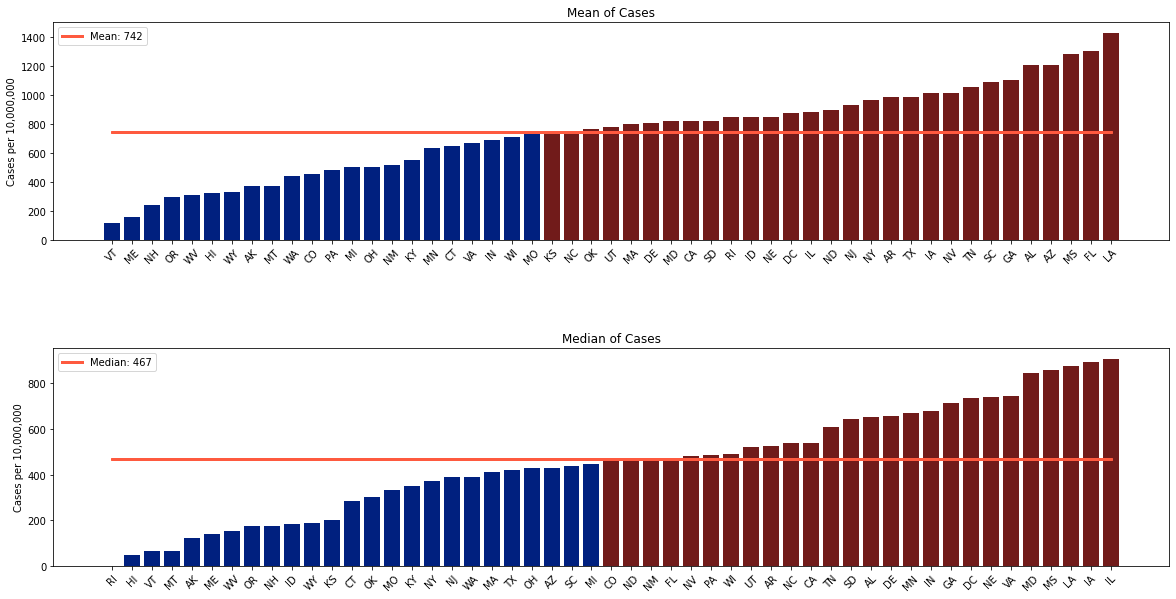

In [13]:
x = df_daily_statistics_cases.index.tolist()
# Sorting columns by ascending order for each statistical measurement.
y_mean = df_daily_statistics_cases.sort_values(by = "mean", ascending = True)["mean"]
y_median = df_daily_statistics_cases.sort_values(by = "median", ascending = True)["median"]
# Creating 2 subplots with padding of .5.
figure, axis = plt.subplots(2, gridspec_kw={'hspace': .5}, figsize = (20,10))
# Creating our subplots.
for axis_num, y_data, title in zip(range(0,3,1), (y_mean, y_median), ("Mean", "Median")):
    # Calculate the statistical measurement for all states.
    stat_data = eval("df_daily_statistics_cases['" + title.lower() + "']." + title.lower() + "()")
    # Necessary due to mode returning an array.
    # Creates bar graph with color based on above/below statistical measurement.
    try:
        bars = axis[axis_num].bar(y_data.index.tolist(), y_data, color = \
                                  ["#711B1A" if data >= stat_data else "#00207F" for data in y_data])
    except:
        # Must use [0] here on stat_data to retrieve mode.
        bars = axis[axis_num].bar(y_data.index.tolist(), y_data, color = \
                                  ["#711B1A" if data >= stat_data[0] else "#00207F" for data in y_data])
    # Beautifying graph.
    axis[axis_num].title.set_text(title + " of Cases")
    axis[axis_num].set_ylabel("Cases per 10,000,000")
    axis[axis_num].tick_params(axis = "x", rotation = 45)
    # Necessary due to mode returning an array.
    # Creates plot of our statistical measurement.
    try:
        axis[axis_num].plot(x, np.full((51), fill_value = stat_data),\
                            linewidth = 3, color = "#FE5A3F", label = (title + ": {:.0f}".format(stat_data)))
    except:
        axis[axis_num].plot(x, np.full((51), fill_value = stat_data),\
                        linewidth = 3, color = "#FE5A3F", label = (title + ": {:.0f}".format(stat_data[0])))
    axis[axis_num].legend(loc = "upper left")
plt.show()

We can see that the daily cases slightly differ from the weekly. The daily may be considered more precise since it takes in the values for each day instead of each week.

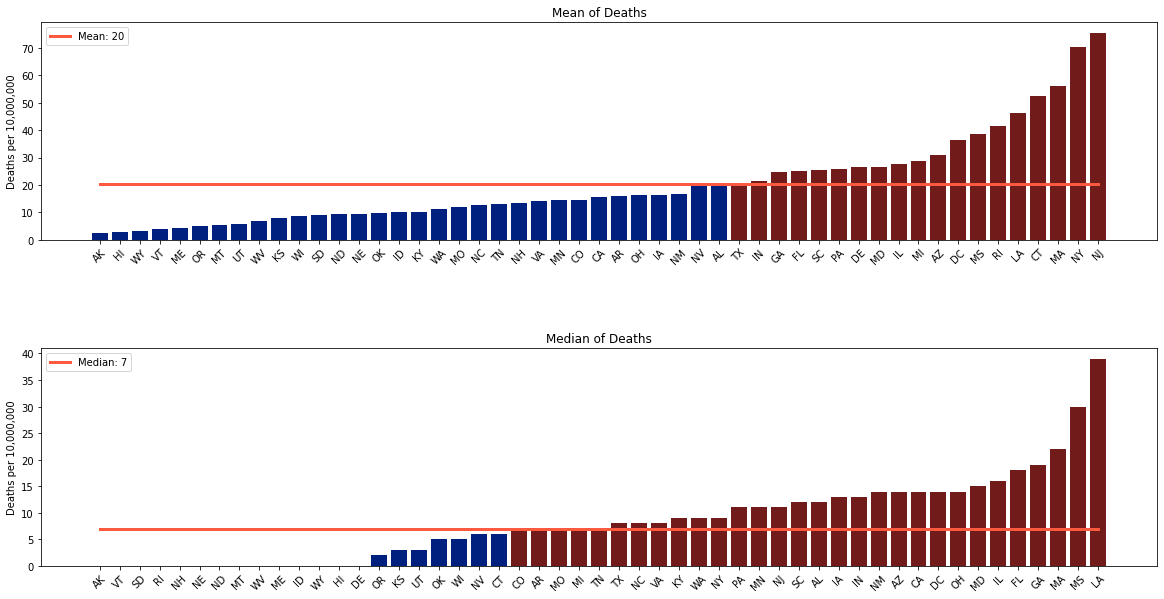

In [14]:
x = df_daily_statistics_deaths.index.tolist()
# Sorting columns by ascending order for each statistical measurement.
y_mean = df_daily_statistics_deaths.sort_values(by = "mean", ascending = True)["mean"]
y_median = df_daily_statistics_deaths.sort_values(by = "median", ascending = True)["median"]
# Creating 2 subplots with padding of .5.
figure, axis = plt.subplots(2, gridspec_kw={'hspace': .5}, figsize = (20,10))
# Creating our subplots.
for axis_num, y_data, title in zip(range(0,3,1), (y_mean, y_median), ("Mean", "Median")):
    # Calculate the statistical measurement for all states.
    stat_data = eval("df_daily_statistics_deaths['" + title.lower() + "']." + title.lower() + "()")
    # Necessary due to mode returning an array.
    # Creates bar graph with color based on above/below statistical measurement.
    try:
        bars = axis[axis_num].bar(y_data.index.tolist(), y_data, color = \
                                  ["#711B1A" if data >= stat_data else "#00207F" for data in y_data])
    except:
        # Must use [0] here on stat_data to retrieve mode.
        bars = axis[axis_num].bar(y_data.index.tolist(), y_data, color = \
                                  ["#711B1A" if data >= stat_data[0] else "#00207F" for data in y_data])
    # Beautifying graph.
    axis[axis_num].title.set_text(title + " of Deaths")
    axis[axis_num].set_ylabel("Deaths per 10,000,000")
    axis[axis_num].tick_params(axis = "x", rotation = 45)
    # Necessary due to mode returning an array.
    # Creates plot of our statistical measurement.
    try:
        axis[axis_num].plot(x, np.full((51), fill_value = stat_data),\
                            linewidth = 3, color = "#FE5A3F", label = (title + ": {:.0f}".format(stat_data)))
    except:
        axis[axis_num].plot(x, np.full((51), fill_value = stat_data),\
                        linewidth = 3, color = "#FE5A3F", label = (title + ": {:.0f}".format(stat_data[0])))
    axis[axis_num].legend(loc = "upper left")
plt.show()

The same can be said for the number of deaths. The death numbers are slightly different in the daily vs the weekly but still roughly the same.

## Compare the US daily to the 5 Countries

In [15]:
num_days = len(world_cases.index)
day_index = []
country_index = []


for country in world_cases.columns[1:]:
    for day_number in range(0, num_days):
        day_index.append("day " + str(day_number+1))
        country_index.append(country)
        
daily_means = pd.DataFrame(index = [country_index, day_index], \
                            columns = ["mean_cases", "mean_deaths", "day"])

world_cases_statistics_daily = pd.DataFrame(index = world_cases.columns[1:], \
                            columns = ["mean", "median"])

world_deaths_statistics_daily = pd.DataFrame(index = world_cases.columns[1:], \
                            columns = ["mean", "median"])

daily_means.index.set_names(['Country', 'Day'])

for country in world_cases.columns[1:]:
    for day_number in range(0, num_days):
        start = day_number
        end = start + 1
        day_cases_mean = int(world_cases.iloc[start:end][country].mean())
        day_deaths_mean = int(world_deaths.iloc[start:end][country].mean())
        day = "day " + str(day_number + 1)
        daily_means.loc[country, day]["mean_cases"] = day_cases_mean
        daily_means.loc[country, day]["mean_deaths"] = day_deaths_mean


        
for country in world_cases_statistics.index:
    world_cases_statistics_daily.loc[country]["mean"] = float(daily_means.loc[country]['mean_cases'].mean())
    world_cases_statistics_daily.loc[country]["median"] = int(daily_means.loc[country]['mean_cases'].median())

    world_deaths_statistics_daily.loc[country]["mean"] = float(daily_means.loc[country]['mean_deaths'].mean())
    world_deaths_statistics_daily.loc[country]["median"] = int(daily_means.loc[country]['mean_deaths'].median())



display(world_cases_statistics_daily)
display(world_deaths_statistics_daily)

                             mean median
Brazil                    901.019    720
Russia                    340.345    374
Pakistan                  54.3146     28
Nigeria                        11      9
Japan                     26.7116     15
United_States_of_America  888.996    839

                              mean median
Brazil                     26.5955     27
Russia                      5.8839      6
Pakistan                   1.07491      0
Nigeria                   0.138577      0
Japan                     0.423221      0
United_States_of_America   24.4157     23

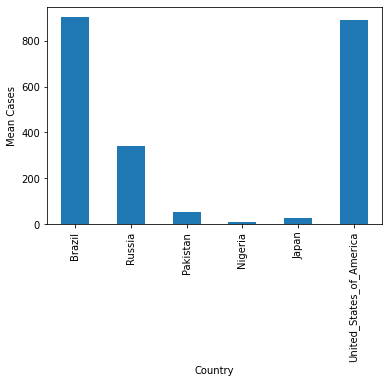

In [16]:
ax = world_cases_statistics_daily['mean'].plot.bar(color = 'C0')
ax.set_ylabel('Mean Cases')
ax.set_xlabel('Country')
plt.show()

The US daily mean is very close to the daily mean of Brazil. Even though these countriees have similar populations, they have very different covid numbers.

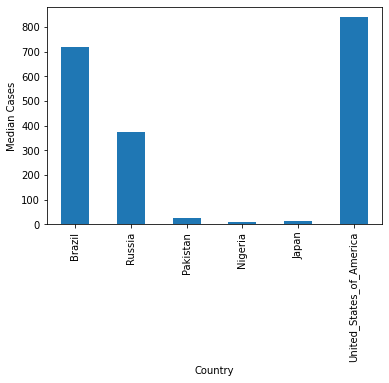

In [17]:
ax = world_cases_statistics_daily['median'].plot.bar(color = 'C0')
ax.set_ylabel('Median Cases')
ax.set_xlabel('Country')
plt.show()

The median of the US is similar to Brazil but is still higher.

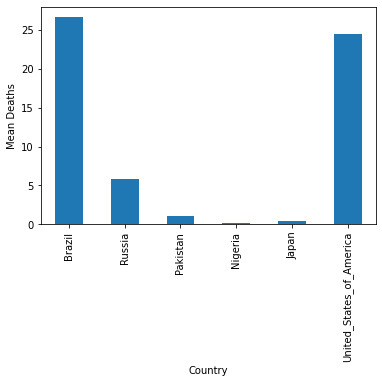

In [18]:
ax = world_deaths_statistics_daily['mean'].plot.bar(color = 'C0')
ax.set_ylabel('Mean Deaths')
ax.set_xlabel('Country')
plt.show()

We can see that even though the US is similar to number of cases, the mean death of Brazil is higher.

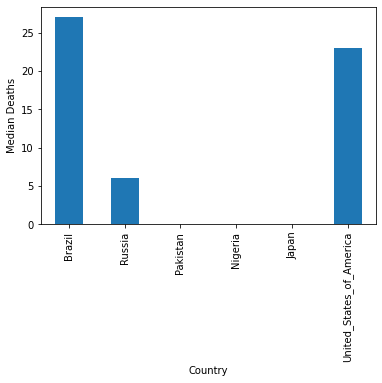

In [19]:
ax = world_deaths_statistics_daily['median'].plot.bar(color = 'C0')
ax.set_ylabel('Median Deaths')
ax.set_xlabel('Country')
plt.show()

Russia is the only country other than US and Brazil that has a median higher than 0.

# Identify peak week of the cases and deaths in US and other countries. 

In [152]:
chosen_countries = ["Brazil", "Russia", "Pakistan", "Nigeria", "Japan", "United_States_of_America"]

In [153]:
def partition_countries_by_week():
    for data_type in ("cases", "deaths"):
        df_world_cases = pd.read_csv("../data/Covid_International/new_" \
                                     + data_type + "_normalized.csv", index_col = 0)

        number_weeks = df_world_cases.shape[0] // 7
        number_days = number_weeks * 7

        column_names = []
        for x in range(0, number_weeks, 1):
            column_names.append("week_" + str(x + 1))
        df_weekly_cases = pd.DataFrame(index = df_world_cases.columns.values,
                                       columns = column_names)
        for week in range(0, number_weeks, 1):
            df_weekly_cases["week_" + str(week + 1)] =\
                df_world_cases.iloc[week * 7:(week * 7) + 7].sum(axis = 0).values
        df_weekly_cases.to_csv("../data/Covid_International/new_" + data_type + "_weekly_normalized.csv")

In [154]:
partition_countries_by_week()

## Peak Week of Cases

In [181]:
df_country_cases = pd.read_csv("../data/Covid_International/new_cases_weekly_normalized.csv", index_col = 0)
for country in chosen_countries:
    peak_week = df_country_cases.loc[country].idxmax()
    peak_value = df_country_cases.loc[country, peak_week]
    print(" ".join([x for x in country.split("_")]), "'s peak week is ",
                   peak_week.split("_")[1], ": ", peak_value, " cases", sep = "")

Brazil's peak week is 30: 15229 cases
Russia's peak week is 41: 5922 cases
Pakistan's peak week is 24: 1839 cases
Nigeria's peak week is 25: 206 cases
Japan's peak week is 31: 779 cases
United States of America's peak week is 29: 14107 cases


## Peak Week of Deaths

In [182]:
df_country_cases = pd.read_csv("../data/Covid_International/new_deaths_weekly_normalized.csv", index_col = 0)
for country in chosen_countries:
    peak_week = df_country_cases.loc[country].idxmax()
    peak_value = df_country_cases.loc[country, peak_week]
    print(" ".join([x for x in country.split("_")]), "'s peak week is ",
                   peak_week.split("_")[1], ": ", peak_value, " deaths", sep = "")

Brazil's peak week is 30: 352 deaths
Russia's peak week is 41: 86 deaths
Pakistan's peak week is 25: 38 deaths
Nigeria's peak week is 25: 6 deaths
Japan's peak week is 17: 14 deaths
United States of America's peak week is 16: 571 deaths
